# Password Analysis

Below looks at 2m passwords released after Yahoo was hacked.

* What are the most common passwords?
* Which characters are used the most?  
* How often are special characters used?
* How many characters are typically used?

<a href="https://medium.com/policygenius-stories/the-sophisticates-guide-to-passwords-4bb6b5d9ecb5">This</a> suggests length is crucial, as hackers have already catalogued 'rainbow tables' of most passwords 8 characters or less

In [1]:
#initialize
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 4

### Import Data

In [6]:
df = pd.read_csv('http://datashaping.com/passwords.txt',skiprows=16,names=(['pw']),quoting=3)  # nrows=10

In [4]:
print('passwords = ',"{:,}".format(df.shape[0])
      ,'\ndups = ',df[df.pw.duplicated()].shape[0] / 2 )

passwords =  2,151,220 
dups =  488.0


In [5]:
print(df.head())
print(df.tail())

             pw
0   07606374520
1  piontekendre
2      rambo144
3     primoz123
4       sal1387
                  pw
2151215     26778982
2151216      brazer1
2151217   usethisone
2151218  scare222273
2151219     anto1962


### Password Length

most common length:  8.0 characters


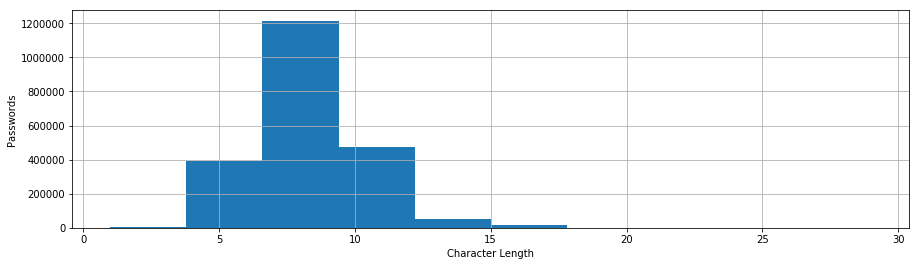

In [6]:
# How many characters do most people use?
df['pwlength']=df.pw.str.len()
pp = df['pwlength'].hist()
z = pp.set_xlabel("Character Length")
z = pp.set_ylabel("Passwords")
print('most common length: ',df['pwlength'].mode().max(), 'characters')

In [7]:
#Look at some of the longest and shortest passwords
print(df.sort_values(by='pwlength',ascending=False).head())
print(df.sort_values(by='pwlength').head())

                                   pw  pwlength
457967  a42bdef285d431054f2848d30afac      29.0
783909  dj-explosion_isan@hotmail.com      29.0
290961  namfon_love_i.p.v@hotmail.com      29.0
883469  111-222-1933email@address.com      29.0
220542  835B2D5E447C64B9A5782DD76353A      29.0
        pw  pwlength
755964   m       1.0
1221451  j       1.0
1056313  3       1.0
1669953  8       1.0
1966571  ;       1.0


### Characters Used
which are most common?

In [8]:
import nltk

pwStr = df.pw.str.cat(sep=' ')

def fnPlotOccurence(fdist):
    df2 = pd.DataFrame.from_dict(fdist, orient='index', columns=['freq'])
    df2['occurence']= df2.freq / len(df.pw.str.cat()) # % of all characters
    df2.sort_index().plot.bar(y='occurence')

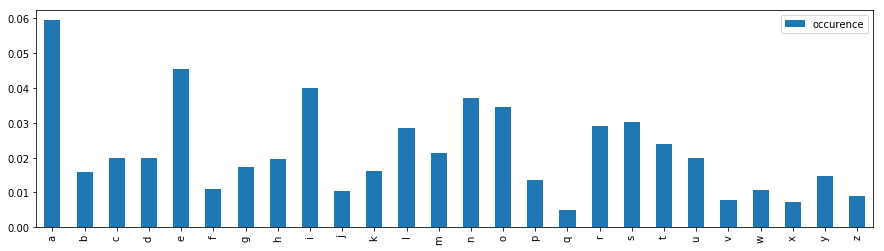

In [9]:
# character frequency
fdist = nltk.FreqDist(ch.lower() for ch in pwStr if ch.isalpha())
fnPlotOccurence(fdist)

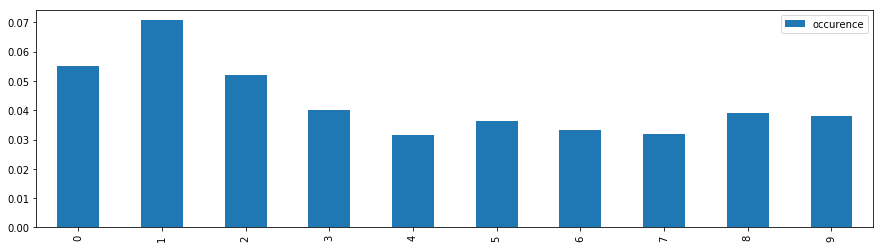

In [10]:
# digit frequency
fdist = nltk.FreqDist(ch.lower() for ch in pwStr if ch.isdigit())
fnPlotOccurence(fdist)

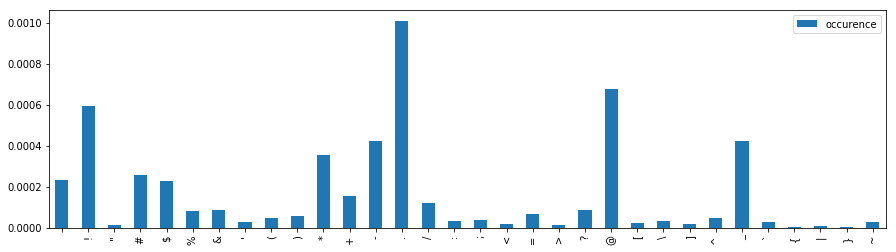

In [11]:
#special character
fdist = nltk.FreqDist(ch.lower() for ch in df.pw.str.cat() if not ch.isalnum())
fnPlotOccurence(fdist)

In [12]:
# how often is special case used?
df['specialChar']=df.pw.apply(lambda s: not str(s).isalnum())
print('people use special characters {:.2%} of the time'.format(
    df.pw[df['specialChar']==True].size / df.pw.size))

people use special characters 3.06% of the time


### Common Phrases
to do: use nltk.util ngrams

In [13]:
import re
from collections import Counter

import ray
import multiprocessing

In [14]:
ray.init()  #kick off multi-threading

@ray.remote
def mostCommonStrings(charLen,s):
    cnt = Counter()
    t = len(s) - (charLen - 1)
    
    for i in range(t):
        
        # a sequence of characters being considered
        char = s[i:i+charLen]                
        
        # let's only look at alpha strings
        allAlpha = True
        for j in range(charLen):
            if not char[j].isalpha():
                allAlpha = False
                break
            
        if allAlpha:
            numFound = len(re.findall(char,s))
            if numFound>1:
                cnt[char] = numFound
    
    return dict(cnt)

2019-05-11 18:20:39,293	WARNING worker.py:1337 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-05-11 18:20:39,302	INFO node.py:469 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-11_18-20-39_3666/logs.
2019-05-11 18:20:39,453	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:34569 to respond...
2019-05-11 18:20:39,583	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:27848 to respond...
2019-05-11 18:20:39,586	INFO services.py:804 -- Starting Redis shard with 1.01 GB max memory.
2019-05-11 18:20:39,619	INFO node.py:483 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-11_18-20-39_3666/logs.
2019-05-11 18:20:39,623	INFO services.py:1427 -- Starting the Plasma object store with 1.51 GB memory using /dev/shm.


{'node_ip_address': '10.0.2.15',
 'redis_address': '10.0.2.15:34569',
 'object_store_address': '/tmp/ray/session_2019-05-11_18-20-39_3666/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-05-11_18-20-39_3666/sockets/raylet',
 'webui_url': None}

In [15]:
threads = multiprocessing.cpu_count()
print(df.size)
batchSize = df.size / threads
batchSize = 100000 / threads
print('threads, batchSize = {}, {}'.format(threads,batchSize))

6453660
threads, batchSize = 4, 25000.0


In [16]:
%%time

for charLen in range(4,9):   # look at strings of len 4 up to 8
    cnt = Counter()
    for i in range(threads):
        s = df[int(i * batchSize) : int(i * batchSize + batchSize) ].pw.str.cat()
        cnt += ray.get(mostCommonStrings.remote(charLen,s)) 
    print("most common {} digit strings are {}".format(charLen,cnt.most_common(5)))

most common 4 digit strings are [('love', 574), ('wang', 286), ('hang', 285), ('chen', 274), ('iang', 256)]
most common 5 digit strings are [('zhang', 182), ('admin', 180), ('ilove', 161), ('angel', 89), ('huang', 87)]
most common 6 digit strings are [('ssword', 64), ('asswor', 62), ('passwo', 59), ('master', 55), ('woaini', 52)]
most common 7 digit strings are [('assword', 60), ('passwor', 59), ('forever', 36), ('dearboo', 33), ('earbook', 33)]
most common 8 digit strings are [('password', 57), ('dearbook', 33), ('iloveyou', 19), ('computer', 12), ('kikugala', 10)]
CPU times: user 5.4 s, sys: 408 ms, total: 5.81 s
Wall time: 4min 49s


In [17]:
ray.shutdown()

In [18]:
df3 = pd.DataFrame.from_dict(cnt, orient='index').reset_index()
if df3.columns.size==2:
    df3.columns = ['char','freq']
    #df3['freq']=df3.freq.apply(lambda x: math.sqrt(x))
    df3['charLen']=df3.char.apply(lambda str: len(str))
print('records=',df3.shape[0])

records= 511


In [2]:
# df3.to_csv('data/pwAnalysis.csv',index=False)
df3 = pd.read_csv('data/pwAnalysis.csv')
df3.head(2)

,char,freq,charLen,word,lem
0,marketin,2,8,0,marketin
1,arketing,2,8,0,arketing


In [3]:
from nltk.corpus import words
df3['word']=df3.char.apply(lambda m: 1 if m.lower() in map(str.lower, words.words()) else 0)

In [4]:
print('most common words are')
df3[df3.word==True].sort_values(['charLen', 'freq'], ascending=[False, False]).char.head(50).str.cat(sep='|')

most common words are


'password|computer|superman|scorpion|football|remember|shopping|princess|atherine|december|security|nicholas|predator|victoria|resident|mercedes|volution|november|sunshine|valentin|caroline|cherokee|anderson|cristina|tropical|twilight|solution|fighting|magdalen|ultimate|shanghai|elephant|danielle|baseball|creative|Marianne|jeremias|michelle|brittany|freehand|together|illinois|samantha|notebook|Sunshine|maverick|spinning|february|constant|giovanni'

In [7]:
#how often do these phrases appear?
df5 = pd.DataFrame({'char':['love','pass','man','wang','dragon','zzzz','and','123','windows']})
df5['freq']= df5.char.apply(lambda ch: df[df.pw.str.lower().str.match(ch.lower(),na=False)].shape[0])
df5['occurence']= df5.char.apply(lambda ch: df[df.pw.str.lower().str.match(ch.lower(),na=False)].shape[0] / df.shape[0])
df5.sort_values(by='freq',ascending=False)

,char,freq,occurence
7,123,11887,0.005526
3,wang,5135,0.002387
0,love,4739,0.002203
2,man,3623,0.001684
6,and,2429,0.001129
1,pass,1812,0.000842
4,dragon,648,0.000301
8,windows,292,0.000136
5,zzzz,112,0.000052


In [8]:
from nltk.stem import WordNetLemmatizer 
import jellyfish

lemmatizer = WordNetLemmatizer()
# nltk.download('wordnet')

df3['lem'] = [lemmatizer.lemmatize(r.char) for r in df3.itertuples()]
df3['phoenetic'] = [jellyfish.metaphone(r.char) for r in df3.itertuples()]

'original count: {}'.format(df3.char.nunique())
'lemmatized count: {}'.format(df3.lem.nunique())
'phoenetic count: {}'.format(df3.phoenetic.nunique())

'original count: 511'

'lemmatized count: 511'

'phoenetic count: 486'

In [10]:
#lemmatizing didn't matter; everything's distinct
#look at phoenitcally similar
df3[(df3.duplicated('phoenetic',keep=False))].sort_values('phoenetic').head(20)

,char,freq,charLen,word,lem,phoenetic
429,asswordy,2,8,0,asswordy,ASWRT
212,assworde,2,8,0,assworde,ASWRT
11,hangyang,2,8,0,hangyang,HNJYNK
377,hangying,2,8,0,hangying,HNJYNK
480,hangqian,2,8,0,hangqian,HNKKN
305,HANGQIAN,2,8,0,HANGQIAN,HNKKN
161,kikugala,10,8,0,kikugala,KKKL
435,cocacola,2,8,0,cocacola,KKKL
57,caroline,2,8,1,caroline,KRLN
449,karolina,2,8,0,karolina,KRLN
